In [1]:
import os
import random
import time
from collections import deque
import tensorflow as tf
from agents.MemoryBuffer import MemoryBuffer
from environment.Simulator import Simulator
from resources.Plots import plot_actions
from resources.Utils import load_object, store_object
import resources.Utils as utils
print(tf.__version__)
import numpy as np

2.0.0


In [3]:
from agents.BinaryStateAgent import BinaryStateAgent
from agents.NeuralNetwork import NeuralNetwork
from environment.BinaryStateEnvironment import BinaryStateEnvironment
from environment.Config import ConfigTimeSeries
from environment.BaseEnvironment import TimeSeriesEnvironment

tf.compat.v1.disable_eager_execution()


def train(train_pct=.5, dataset="A1Benchmark"):
    nn_type = "lstm_binary"
    tf.compat.v1.disable_eager_execution()
    dqn = NeuralNetwork(input_dim=25,
                                input_neurons=25, hidden_neurons=64, type=nn_type, optimizer_lr=0.0001).keras_model
    modelname = "{}_{}_{}".format(nn_type, str(train_pct), dataset)
    for subdir, dirs, files in os.walk("../ts_data/"):
        for file in files:
            if file.find('.csv') != -1:
                # break at percentage
                if files.index(file) >= len(files)*train_pct:
                    print("Finished Training saving model: {}".format(modelname))
                    dqn.save(modelname)
                    break
                config = ConfigTimeSeries()
                env = BinaryStateEnvironment(
                    TimeSeriesEnvironment(verbose=False, filename="./{}/{}".format(dataset,file), config=config), steps=25)

                agent = BinaryStateAgent(dqn=dqn, memory=MemoryBuffer(max=500000, id="binary_agent"), alpha=0.0001, gamma=0.99,
                                         epsilon=1, epsilon_end=0.0, epsilon_decay=0.5, fit_epoch=10, action_space=2,                                          batch_size=256)
                simulation = Simulator(10, agent, env,2)
                agent.memory.init_memory(env=env)
                simulation.run()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 25)            2800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 64)            23040     
_________________________________________________________________
dense (Dense)                (None, 25, 64)            4160      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3202      
Total params: 33,202
Trainable params: 33,202
Non-trainable params: 0
_________________________________________________________________
Successfully stored to memory_binary_

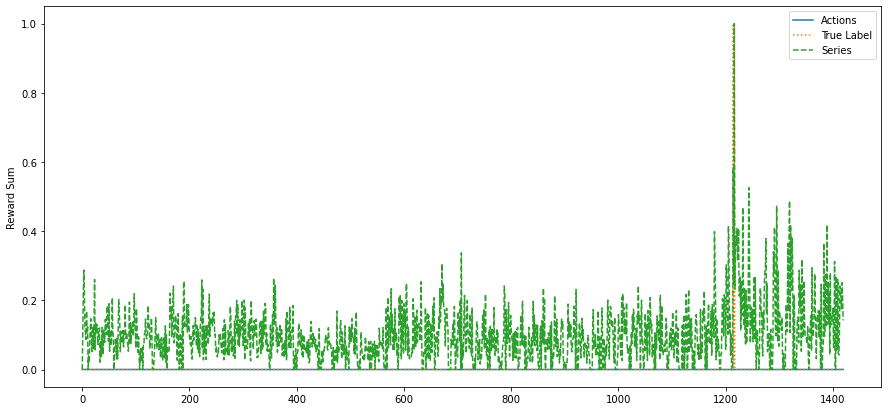

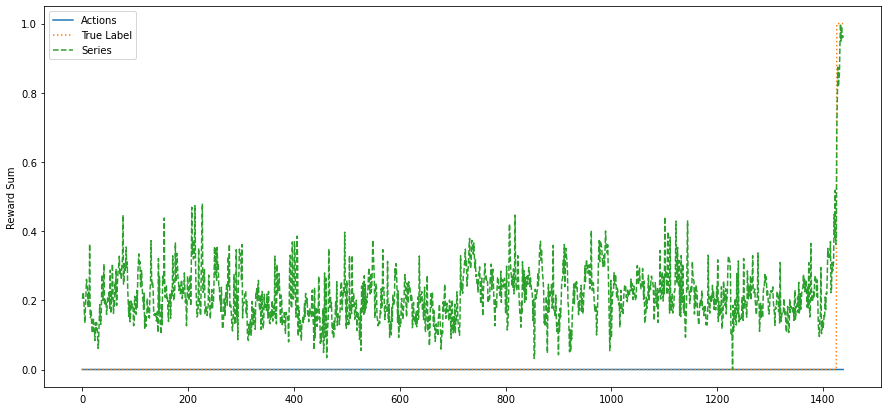

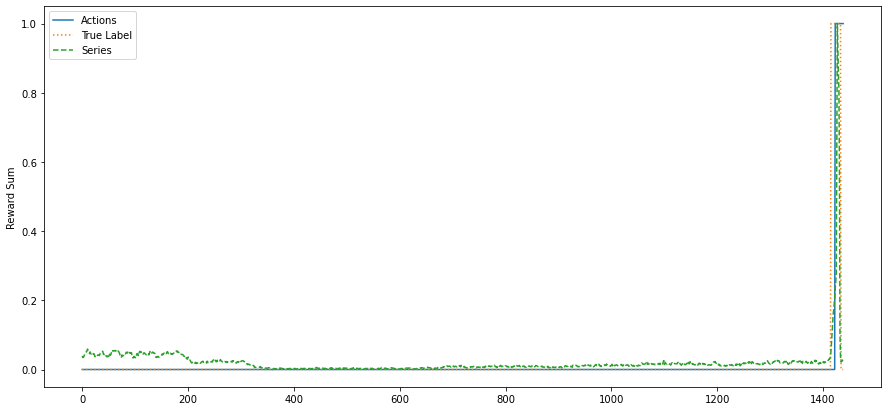

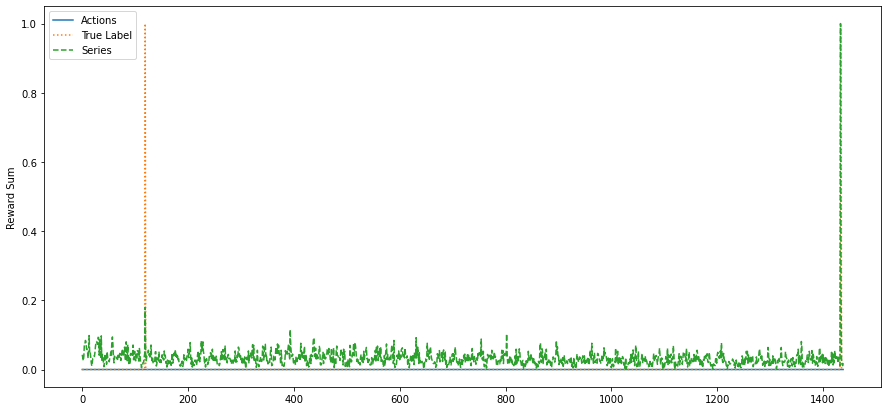

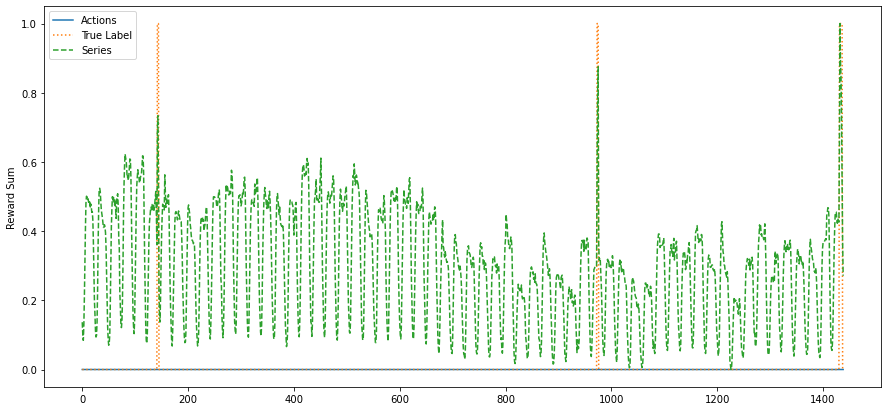

KeyboardInterrupt: 

In [4]:
train()

In [ ]:
model_dir = "./model_test"
dataset_dir = "A1Benchmark"

def test(model_dir, dataset_dir, test_pct=0.5):
    model = tf.keras.models.load_model(model_dir)
    for subdir, dirs, files in os.walk(f"../ts_data/{dataset_dir}"):
        for file in files:
            if file.find('.csv') != -1:
                if files.index(file) < len(files)*test_pct:
                    pass
                    # Trained on these files
                else:
                    config = ConfigTimeSeries()
                    env = BinaryStateEnvironment(
                        TimeSeriesEnvironment(verbose=False, filename=f"./{dataset_dir}/{file}", config=config), steps=25)

                    agent = BinaryStateAgent(dqn=model, memory=None, alpha=0.0001, gamma=0.9, epsilon=0.2, epsilon_end=0.01, epsilon_decay=0.5, fit_epoch=10, action_space=2,                                          batch_size=256)
                    simulation = Simulator(25, agent, env,2, testing=True)
                    simulation.run()

In [ ]:
test(model_dir, dataset_dir)